# Introductoin


This tutorial focuses on how representation/knowledge is learnt in deep neural networks. 

In the beginning, the network's weights are initialised from random distributions (e.g., uniform or Gaussian). Throughout the *learning process*, they get tuned to a set of useful features to perform the task they are being optimised to.

Broadly speaking, the learning process consists of:
1. Comparing the network's output to the expected value (ground truth).
2. Using the backpropagation algorithm to compute the gradient of the loss function with respect to all network parameters.
3. Updating the weights by stepping in the direction of the gradient for a given parameter. 

These three steps correspond to the following lines of code, typically implemented in any deep learning project (e.g., [building a DNN project notebook](https://github.com/ArashAkbarinia/mbb/blob/main/notebooks/build_DNN_project.ipynb) that we saw in the previous class.)
```
    loss = criterion(output, target)
    optimizer.zero_grad()
    loss.backward()
    optimizer.zero_grad()
```

By the end of this class, you will have a better understanding of:
* What is a loss function?
* The intuition behind optimisation algorithms.
* How do hyperparameters influence the learning process?
 
To answer these questions, we will look at a few simple binary classification toy examples.

# 0. Preparation
## Packages

Let's start with all the necessary packages to implement this tutorial.

 * [numpy](https://numpy.org/) is the main Python package for scientific computing. It's often imported with the `np` shortcut.
 * [matplotlib](https://matplotlib.org/) is a library to plot graphs in Python.
 * [torch](https://pytorch.org/docs/stable/index.html) is a deep learning framework that allows us to define networks, handle datasets, optimise a loss function, etc.

In [1]:
# importing the necessary packages/libraries
import numpy as np
from matplotlib import pyplot as plt
import random

import torch
import torch.nn as nn
import torchvision

## Device
To execute our code, we choose CPU or GPU based on the hardware availability. We check this by calling the `torch.cuda.is_available()` function that returns whether a CUDA driver is available.

In this toy example, even the CPU would be sufficient. although it will be fairly slow. However, in real-world applications, a GPU is always necessary.

In [2]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# 1. Dataset

We define four datasets of 2D points (inspired by [Tensorflow Playground](https://playground.tensorflow.org/) and [ConvnetJS Demo](https://cs.stanford.edu/people/karpathy/convnetjs/demo/classify2d.html)):
1. *Linear*: the data points are linearly separable.
2. *Circular*: the data points are separable by the radii of their circles.
3. *Spiral*: the data points follow the equation of [Archimedean spiral](https://en.wikipedia.org/wiki/Archimedean_spiral) in different directions.
4. *Random*: the data points are randomly generated in a 2D space.

The task is **binary classification**: the network has to learn to which category each point belongs.

## Dataset utility functions
We define a set of utility functions to generate our four datasets. All data generator functions return two variables:
* `points` is a list of `n` points with their $(x, y)$ coordinates. The shape of this array is $n \times 2$.
* `labels` corresponding to each point specifying its category (i.e., 0 or 1 ). The shape of this array is $n$.

The `points` for each dataset are already centred at 0, therefore, we don't need to call the normalize function.

In [3]:
def random_2d(num_points):
    """"Generates a dataset of 2D points in the range of [-1, 1] with a random label assigned to them."""
    points = np.random.uniform(-1, 1, (num_points, 2))
    labels = np.random.randint(0, 2, num_points)
    return points, labels


def circular_2d(num_points):
    """Generated a dataset of circular 2D points."""
    half_num_pts = num_points // 2
    # Those with label 0 have a radius in the range of [0.1, 0.3]
    # Those with label 1 have a radius in the range of [0.5, 0.7]
    polar_pts = np.array([
        *np.array([np.random.uniform(0.1, 0.3, half_num_pts), np.random.uniform(0, np.pi * 2, half_num_pts)]).T,
        *np.array([np.random.uniform(0.5, 0.7, half_num_pts), np.random.uniform(0, np.pi * 2, half_num_pts)]).T
    ])
    # converting the polar points to cartesian coordinates
    points = np.array([polar_pts[:, 0] * np.sin(polar_pts[:, 1]), polar_pts[:, 0] * np.cos(polar_pts[:, 1])]).T
    labels = np.array([*[0] * half_num_pts, *[1] * half_num_pts])
    return points, labels

def spiral_2d(num_points):
    """Generates a dataset of spiral 2D points."""
    half_num_pts = num_points // 2
    points = []
    labels = []
    # Points with label 0 swirl clockwise.
    for i in range(half_num_pts):
        r = i / half_num_pts * 5
        t = 1.75 * i / half_num_pts * 2 * np.pi + 0
        points.append([r * np.sin(t) + np.random.uniform(-0.1, 0.1), r * np.cos(t) + np.random.uniform(-0.1, 0.1)])
        labels.append(0)
    # Points with label 1 swirl unclockwise.
    for i in range(half_num_pts):
        r = i / half_num_pts * 5
        t = 1.75 * i / half_num_pts * 2 * np.pi + np.pi
        points.append([r * np.sin(t) + np.random.uniform(-0.1, 0.1), r * np.cos(t) + np.random.uniform(-0.1, 0.1)])
        labels.append(1)
    return np.array(points), np.array(labels)

def linear_2d(num_points):
    """Generates a dataset of 2D poins that are linearly seperable."""
    points = np.random.uniform(-1, 1, (num_points, 2))
    # The boundary line.
    line = np.array([[-0.9, -0.7], [1.0, 0.6]])
    # Points with label 0 are above the line and points with label 1 are below the line.
    is_above = lambda p,l: np.cross(p - l[0], l[1] - l[0]) < 0
    labels = []
    for p in points:
        labels.append(0 if is_above(p, line) else 1)
    return points, np.array(labels)

**Bonus Python question**: The code for `spiral_2d` can be written in a nicer parametric way to avoid double-for-loops. Can you implement that?

## Visualising the dataset
We create the `plot_db` function that plots all the points of a dataset using the `scatter` function from `matplotlib`. The points are colour coded according to their labels.:
* Points with label <span style="color:red">**0**</span> are in <span style="color:red">**red**</span>.
* Points with label <span style="color:blue">**1**</span> are in <span style="color:blue">**blue**</span>.

In [4]:
def plot_db(data, title, ax=None):
    points, labels = data
    
    xs = points[:, 0]
    ys = points[:, 1]
    cdict = {0: 'red', 1: 'blue'}

    if ax is None:
        # if axis is not provided create a new figure.
        fig = plt.figure(figsize=(4, 4))
        ax = fig.add_subplot(1, 1, 1)
    for l in np.unique(labels):
        ix = np.where(labels == l)
        ax.scatter(xs[ix], ys[ix], c=cdict[l], label=l, s=10)
    ax.legend()
    ax.set_title(title)
    ax.axis('equal')

For each dataset type, we sample 1000 points. We put all four datasets into a dictionary. This allows us to access them easily by looping through all the dictionary items, for instance for visualisation.

In [5]:
number_points = 1000
dbs = {
    'random_data': random_2d(number_points),
    'circular_data': circular_2d(number_points),
    'spiral_data': spiral_2d(number_points),
    'linear_data': linear_2d(number_points)
}

Intuitively from the datasets plots, we can see that except for the random dataset, the rest are easily separable (at least to our eyes). The question we study in this tutorial is whether this holds for deep networks as well.

We can also observe that the $(x, y)$ coordinates of all four datasets are in the range of $(-std, +std)$. Therefore we do not need to apply the normalisation function (`torchvision.transforms.Normalize(mean, std)`).

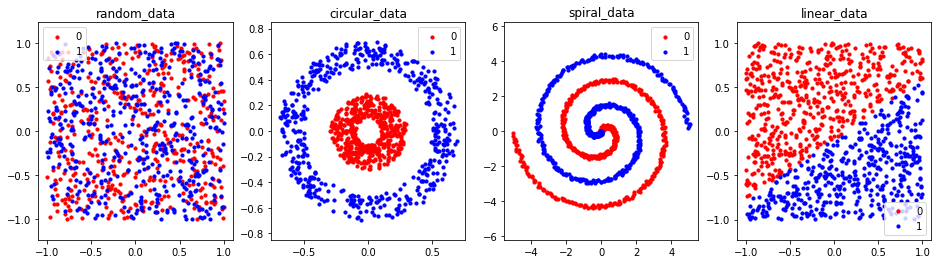

In [6]:
fig = plt.figure(figsize=(16, 4))
for db_ind, (db_key, db_val) in enumerate(dbs.items()):
    ax = fig.add_subplot(1, len(dbs), db_ind+1)
    plot_db(db_val, db_key, ax)

## Train/test splits

For each dataset, we split the sampled points into two sets:
 * **train** containing 90% of the points.
 * **test** containing 10% of the points.

In [7]:
train_dbs = dict()
test_dbs = dict()
num_tests = number_points // 10
for db_ind, (db_key, db_val) in enumerate(dbs.items()):
    points, labels = db_val
    # creating a sorted array from 0 to 999 (number_points).
    shuffle_inds = np.arange(number_points)
    # we shuffle around the indices to obtain random train/test sets.
    # the first 900 indices will belong to the training set and the rest test set
    random.shuffle(shuffle_inds)
    train_dbs[db_key] = points[shuffle_inds[:-num_tests]], labels[shuffle_inds[:-num_tests]]
    test_dbs[db_key] = points[shuffle_inds[-num_tests:]], labels[shuffle_inds[-num_tests:]]

Plotting the **train** set. Visually the difference to the entire set is unrecognisable.

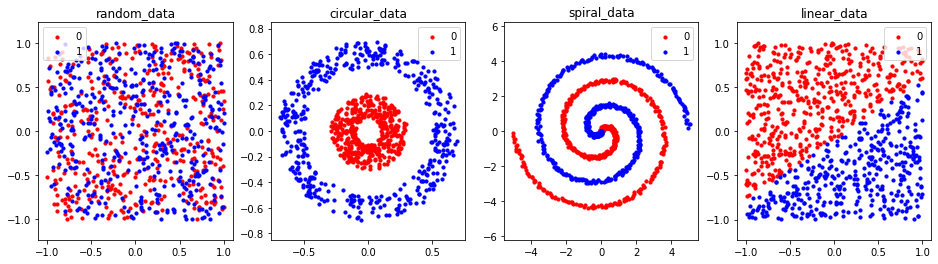

In [8]:
fig = plt.figure(figsize=(16, 4))
for db_ind, (db_key, db_val) in enumerate(train_dbs.items()):
    ax = fig.add_subplot(1, len(dbs), db_ind+1)
    plot_db(db_val, db_key, ax)

Plotting the **test** set. We can observe that points are much more sparse in comparison to the training set.

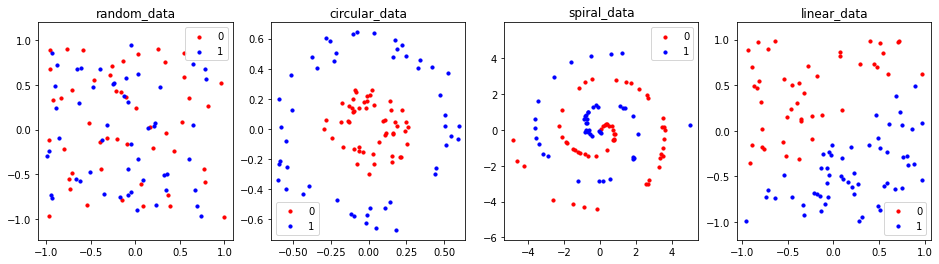

In [9]:
fig = plt.figure(figsize=(16, 4))
for db_ind, (db_key, db_val) in enumerate(test_dbs.items()):
    ax = fig.add_subplot(1, len(dbs), db_ind+1)
    plot_db(db_val, db_key, ax)

**Python bonus question**: we have used identical 4 lines of code to plot full/train/test datasets. Make the code nicer by creating a function for plotting four datasets. Call this function three times for full/train/test sets.

## Evaluation

We define accuracy as the metric to report the performance of an algorithm in correctly classifying the points into two categories. We define a function to compute the `accuracy` of the output in comparison to the ground truth.

In [10]:
def accuracy(y_pred, y_true):
    """Calculate accuracy (a classification metric)"""
    correct = torch.eq(y_true, y_pred).sum().item() # torch.eq() calculates where two tensors are equal
    acc = (correct / len(y_pred)) * 100 
    return acc

# 2. Model

We have successfully created our datasets. Next, we design a simple network.
 * `Simple2DNetwork` is a subclass of the `nn.Module`. It must implement the `forward` function.
 * It only contains 3 layers, two linear and one non-linear activation function (ReLU).

In [11]:
class Simple2DNetwork(nn.Module):
    def __init__(self, weight_init='uniform', nonlinearity=True):
        super().__init__()
        self.linear1 = nn.Linear(in_features=2, out_features=5) # in_features must be 2 because our data is (x, y).
        self.linear2 = nn.Linear(in_features=5, out_features=1) # out_features equals 1 because of binary classification.
        self.nonlinearity = nonlinearity
        if nonlinearity:
            self.relu = nn.ReLU()
        
        # initialising the weights and their biases
        if weight_init == 'uniform':
            nn.init.uniform_(self.linear1.weight)
            nn.init.uniform_(self.linear2.weight)
        elif weight_init == 'xavier':
            nn.init.xavier_normal_(self.linear1.weight)
            nn.init.xavier_normal_(self.linear2.weight)
    
    # Define a forward method containing the forward pass computation
    # It's common to use the same variable name throughout the forward stream, in this case "x".
    # This is only to simplify coding, input/outpts to all layers would have the same variable name.
    def forward(self, x):
        # The input data is processed by the first linear layer.
        x = self.linear1(x)
        if self.nonlinearity:
            # The output of the first layer is rectified with ReLU.
            x = self.relu(x)
        # The second linear layer produces the output value.
        x = self.linear2(x)
        return x

# Creating an instance of the model and send it to target device
model = Simple2DNetwork().to(device)
print(Simple2DNetwork())

Simple2DNetwork(
  (linear1): Linear(in_features=2, out_features=5, bias=True)
  (linear2): Linear(in_features=5, out_features=1, bias=True)
  (relu): ReLU()
)


In theory, we could have created our `Simple2DNetwork` with fewer lines of code using `nn.Sequential`:
```
    model = nn.Sequential(
        nn.Linear(in_features=2, out_features=5),
        nn.ReLU(),
        nn.Linear(in_features=5, out_features=1)
    )
```
This implementation is useful when prototyping very simple networks. As soon as the network becomes a bit more complicated (e.g., the weight-initialisation/nonlinearity if statement), one has to create a `class` as we did in the previous cell. 

# 3. Loss

How do we know if the output of our network is good or bad? We need a metric to quantify how close the output is to ground truth. A *loss* function calculates the error of the output. The smaller the better. 

**Loss function** measures the degree of dissimilarity of obtained result to the target value, and it is the loss function that we want to minimise during training. To calculate the loss we make a prediction using the inputs of our given data sample and compare it against the true data label value.

There are several loss functions implemented in deep learning frameworks (e.g. [PyTorch Loss Functions](https://pytorch.org/docs/stable/nn.html#loss-functions). Going through all of them is beyond the purpose of this tutorial. We only look at four of those in this tutorial:
* `nn.L1Loss` is the mean absolute error (MSA).
* `nn.MSELoss` is the mean square error (MSE) also known as L2.
* `nn.SmoothL1Loss` and `nn.HuberLoss` combine L1 (MSA) and L2 (MSE) together.
* `nn.BCELoss` (Binary Cross Entropy) is designed for binary classification problems (contrary to the other losses explained above that are typically used in a regression problem). In practice, we often use [BCEWithLogitsLoss](https://pytorch.org/docs/stable/generated/torch.nn.BCEWithLogitsLoss.html) that combines a *Sigmoid* layer and the *BCELoss* in one single class. 

To have a better intuition about each of these loss functions, we plot the error as a function of prediction value for a scenario where the ground truth equals 0.

Qualitatively all the "regression" losses (i.e., *L1, MSE, SmoothL1 and Huber*) are similar but the degree of smoothness varies from the minimum to maximum error. It can also be noted that the maximum error varies in those losses.

In the "classification" loss (*Binary Cross Entropy*) error exponentially increases as prediction deviates from the ground truth.

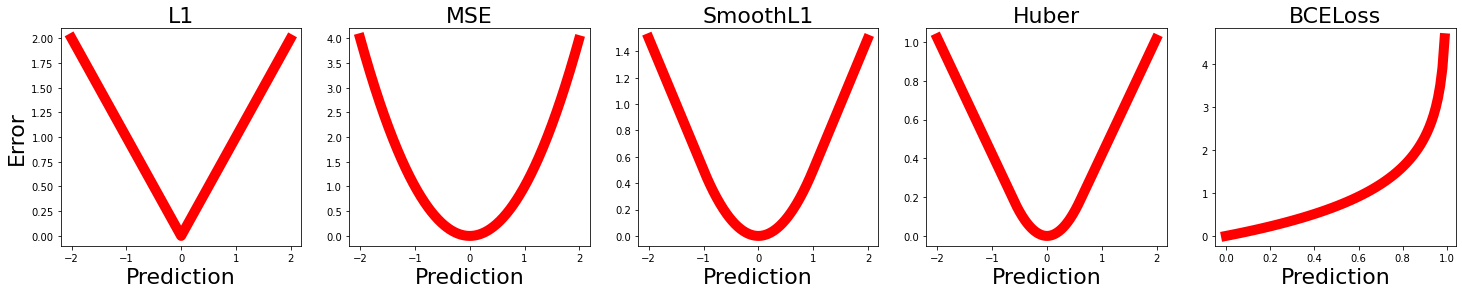

In [12]:
losses = {
    'L1': nn.L1Loss(reduction='none'),
    'MSE': nn.MSELoss(reduction='none'),
    'SmoothL1': nn.SmoothL1Loss(reduction='none'),
    'Huber': nn.HuberLoss(reduction='none', delta=0.6),
    'BCELoss': nn.BCELoss(reduction='none'),
}

fig = plt.figure(figsize=(5 * len(losses), 4))
for loss_ind, (loss_key, loss_val) in enumerate(losses.items()):
    if loss_key in ['BCELoss']:
        # in Binary Cross Entropy the output is between o to 1 (corresponding to two categories).
        x_vals = torch.tensor(np.arange(0, 1, 0.01))
        target = torch.zeros(x_vals.shape).double()
    else:
        x_vals = torch.tensor(np.arange(-2, 2, 0.01))
        target = torch.zeros(x_vals.shape)
    ax = fig.add_subplot(1, len(losses), loss_ind+1)
    y_vals = loss_val(x_vals, target)
    ax.plot(x_vals, y_vals, color='red', linewidth=10)
    ax.set_title(loss_key, size=22)
    ax.set_xlabel('Prediction', size=22)
    if loss_ind == 0:
        ax.set_ylabel('Error', size=22)

## Custom loss
On many occasions, one needs to implement its own loss function. For instance, imagine circular data (e.g., hue or angle). In these scenarios, the error between $0$ and $2 \pi$ degree should be 0. If we use the above-mentioned loss, the error would be the maximum error.

**Question** for one of the regression loss functions (e.g., MSE) implement its circular version.

# 4. Optimizer

![](https://1349742019-files.gitbook.io/~/files/v0/b/gitbook-legacy-files/o/assets%2F-LGHUhl6VYqrZm4Re77O%2F-LGHay3_3SD1W_7T7wut%2F-LGHb1O2LFqXqdQwZ0Hi%2FScreen%20Shot%202018-06-29%20at%204.19.11%20PM.png?alt=media&token=379fb74a-9549-4156-847f-0b7006357c16)

If you are on top of a large valley and want to navigate to the bottom of it (in this picture the lake), what would be the best strategy? It is very hard to see an optimal way. So we use an iterative method, to improve it every time.

1. **Random search**: having a set of W, and just TRY. And using it would be horrible and need a lifetime to finish.
2. Using the local geometry. Maybe we can’t just see the bottom of the valley, but **use your foot to feel the slope of the ground and take which way will take you a bit down** to the valley.
   * **What is the slope?** The slope is the derivative of the loss function.
   * **Gradient**: it will give you the direction of the greatest increase to the target function; and if you look at the negative gradient, you will find the direction of the greatest decrease to the target function. 

There are several different optimizers. Read more about them [here](https://sisyphus.gitbook.io/project/deep-learning-basics/basics/optimization).

## PyTorch gradients
To compute those gradients, *PyTorch* has a built-in differentiation engine called `torch.autograd`. It supports the automatic computation of gradients for any computational graph.

We can only obtain the `grad` properties for the leaf nodes of the computational graph, which have the `requires_grad` property set to `True`. For all other nodes in our graph, gradients will not be available.

By default, all tensors with `requires_grad=True` are tracking their computational history and support gradient computation. For instance, if we print the weights of one layer in our model:
```
    print(model.linear1.weight)
```

We see that `requires_grad=True`:

```
    Parameter containing:
    tensor([[0.7372, 0.4555],
            [0.5298, 0.3239],
            [0.8900, 0.8310],
            [0.4538, 0.2562],
            [0.8395, 0.6339]], device='cuda:0', requires_grad=True
```

There are some cases when we do not need to compute the gradients, for example:
 * **Evaluation**: when we have trained the model and just want to apply it to some input data, i.e. we only want to do forward computations through the network.
 * **Transfer-learning** when we want to transfer a set of weights from a pretrained network to a new network without altering them (also known as **frozen weights**).

## Constructing an optimizer

In this toy example, we create an instance of the Stochastic Gradient Descent (SGD) optimizer.

`torch.optim.SGD` requires at least two arguments:
* `params` which parameters to optimise, in this scenario all our model's parameters.
* `lr` (learning rate) which defines how fast the parameters are to be updated. Smaller values yield slow learning speed, while large values may result in unpredictable behaviour during training.

In our example, all parameters are updated with a unique learning rate. However, `torch.optim` also support specifying per-parameter options. To do this, you have to pass in an iterable of [dict](https://docs.python.org/3/library/stdtypes.html#dict)s. For instance:
```
    optimizer = torch.optim.SGD(params=[
                    {'params': model.linear1.parameters()},
                    {'params': model.linear2.parameters(), 'lr': 1e-3}
                ], lr=learning_rate)
```
Sets a different learning rate for the `linear2` layer.

For more details, see [PyTorch documentation](https://pytorch.org/docs/stable/optim.html).

In [19]:
learning_rate = 0.1
optimizer = torch.optim.SGD(params=model.parameters(), lr=learning_rate)

# 5. Weights initialisation

In the valley picture, depending on where you're standing you might see different paths. Your **initial position** can influence your journey and where you end up. Correspondingly, in neural networks, the initial weights of all layers can have an impact on the learning outcome. While this is outside of the scope of this tutorial. We just look at a few **weight initialization** techniques to familiarise ourselves with this possibility. [torch.nn.init](https://pytorch.org/docs/stable/nn.init.html) supports several diferent initilisation techniques.

A few cells back where we defined our model, we used these few lines to support two initialisation, namely, `uniform` and `xavier_normal`:
```
    if weight_init == 'uniform':
        nn.init.uniform_(self.linear1.weight)
        nn.init.uniform_(self.linear2.weight)
    elif weight_init == 'xavier':
        nn.init.xavier_normal_(self.linear1.weight)
        nn.init.xavier_normal_(self.linear2.weight)
```

## Untrained features
Let's make a prediction using our model without any training. How good *untrained features* can do in this binary classification problem?

In this tutorial, we look at the linear dataset.
**Question**: is there a performance difference on other datasets?

To input our model with the test datasets, we have to first convert them from `numpy arrays` to `torch tensors`. We simply do that by calling the `torch.tensor` function. Note that this toy example is very small and we don't need to pass the data to the model in different batches. Therefore, we don't need to use the dataloader routines (`torch.utils.data.DataLoader`) common to deep learning projects (e.g., [building a DNN project notebook](https://github.com/ArashAkbarinia/mbb/blob/main/notebooks/build_DNN_project.ipynb) that we studied in the previous class).

In [14]:
which_db = 'linear_data'
input_data = torch.tensor(test_dbs[which_db][0]).float().to(device)
target = torch.tensor(test_dbs[which_db][1]).to(device)

model.eval()
untrained_preds = model(input_data)
print(f"Length of predictions: {len(untrained_preds)}, Shape: {untrained_preds.shape}")
print(f"Length of test samples: {len(target)}, Shape: {target.shape}")
print(f"\nFirst 10 predictions:\n{untrained_preds[:10]}")
print(f"\nFirst 10 test labels:\n{target[:10]}")

Length of predictions: 100, Shape: torch.Size([100, 1])
Length of test samples: 100, Shape: torch.Size([100])

First 10 predictions:
tensor([[-0.2465],
        [ 0.7210],
        [-0.3546],
        [-0.2598],
        [-0.1450],
        [-0.2293],
        [ 0.2384],
        [-0.2217],
        [-0.0507],
        [-0.1491]], device='cuda:0', grad_fn=<SliceBackward0>)

First 10 test labels:
tensor([1, 0, 1, 0, 1, 1, 1, 1, 1, 0], device='cuda:0')


From the output of the previous cell, we can observe that the model output is a continuous value contrary to the ground truth that is discrete (0 or 1). This is because the model output is a probability of belonging to category 0 or 1.:
* The closer to 0, the more the model thinks the sample belongs to class 0.
* The closer to 1, the more the model thinks the sample belongs to class 1.

More specifically:
* If `pred_probs` < 0.5, `y=0` (category 0)
* If `pred_probs` >= 0.5, `y=1` (category 1)

So, to compute the accuracy, we should convert the probabilities to a label by the above equation.

Furthermore, we can see that the shape of the prediction is `[100, 1]` therefore we have to call the `squeeze()` function to get rid of this unnecessary extra dimension and convert the prediction to a vector.

In [21]:
untrained_preds_labels = untrained_preds >= 0.5
untrained_acc = accuracy(untrained_preds_labels.squeeze(), target)
print('The accuracy with untrained features: %.1f%%.' % untrained_acc)

The accuracy with untrained features: 44.0%.


We obtain an accuracy close to the chance level ($50\%$) demonstrating that the untrained features cannot solve the task and they need to be tuned.

## Xavier Normal Distribution
Let's fill in our model with [xavier_normal](https://pytorch.org/docs/stable/nn.init.html#torch.nn.init.xavier_normal_) and check whether the initial performance would be different. The initial performance is still at the chance level.

**Question**: investigate whether the initialisation technique has an impact on the training.

In [24]:
model = Simple2DNetwork('xavier').to(device)
model.eval()
untrained_preds = model(input_data)
untrained_preds_labels = untrained_preds >= 0.5
untrained_acc = accuracy(untrained_preds_labels.squeeze(), target)
print('The accuracy with Xavier untrained features: %.1f%%.' % untrained_acc)

The accuracy with Xavier untrained features: 44.0%.


# 6. Backpropagation

Backpropagation computes the gradient of a loss function with respect to the weights of the network for a single input–output example, and does so efficiently, computing the gradient one layer at a time, iterating backwards from the last layer to avoid redundant calculations of intermediate terms in the chain rule [(Wikipedia)](https://en.wikipedia.org/wiki/Backpropagation). For a more detailed walkthrough of this process, check out this video on [backpropagation from 3Blue1Brown](https://www.youtube.com/watch?v=tIeHLnjs5U8).

![](https://www.researchgate.net/publication/356390636/figure/fig2/AS:1094521567875074@1637965685089/An-overview-of-backpropagation-a-Role-of-backpropagation-in-a-neural-network-b.ppm)

Intuitively, to update layers' weights, we need to determine the effect of changing weights for a given layer on the final error (also known as the partial derivative of the error function with respect to that weight). To do that we can use the **chain rule** to propagate error gradients backwards through the network.

PyTorch does that for us by calling the `loss.backward()` function.

# 7. The full picture

We have all the building blocks for training our network. Now we can check how loss, optimizer and backpropagation come to the full picture. The entire processing pipeline can be summarised in five points:
1. **Forward pass**: make a prediction with the current set of weights. In the code language, `prediction = model(input_data)` which calls the `forward` function of our model.
2. **Computing loss**: check how off the prediction is according to the loss function. In the code language, `loss = criterion(prediction, target)`.
3. **Reseting gradients**: to prevent double-counting the gradients we explicitly zero them at each iteration. In code lanague, `optimizer.zero_grad()`.
4. **Backpropagating**: backward pass to propagate the error to all model parameters. In code language, `loss.backward()`.
5. **Updating weights**: updating model parameters based on the calculated derivatives. In code language, `optimizer.step()`.

In [25]:
def epoch_loop(model, db, criterion, optimiser):
    # usually the code for train/test has a large overlap.
    is_train = False if optimiser is None else True

    # model should be in train/eval model accordingly
    model.train() if is_train else model.eval()
    with torch.set_grad_enabled(is_train):
        # moving the image and GT to device
        input_data = torch.tensor(db[0]).float().to(device)
        target = torch.tensor(db[1]).float().to(device)
        # 1. forward pass
        prediction = model(input_data)
        # making it one hot vector
        prediction = prediction.squeeze()
        
        pred_labels = prediction >= 0.5

        # 2. computing the loss function
        loss = criterion(prediction, target)
        # computing the accuracy
        acc = accuracy(pred_labels, target)

        if is_train:
            # 3. reseting gradients
            optimizer.zero_grad()
            # 4. Backpropagating the loss
            loss.backward()
            # 5. Updating weights
            optimizer.step()
    return acc, loss.item(), pred_labels.detach().cpu().numpy()

## Train/test one a single dataset

Let's train our network on the *circular_data* with the *L1* loss.

**Questions** play with other datasets and loss functions:
 * Is there a single loss function that works best across all datasets?
 * What happens when you decrease the learning rate?
 * What happens when you reuces the number of epochs?
 * Do we need the

In [27]:
model = Simple2DNetwork().to(device)

criterion = nn.L1Loss()

learning_rate = 0.1
optimizer = torch.optim.SGD(params=model.parameters(), lr=learning_rate)

# doing epoch
which_db = 'circular_data'

epochs = 1000
print_freq = epochs // 10
initial_epoch = 0
train_logs = {'acc': [], 'loss': [], 'pred': []}
val_logs = {'acc': [], 'loss': [], 'pred': []}
for epoch in range(initial_epoch, epochs):
    train_log = epoch_loop(model, train_dbs[which_db], criterion, optimizer)
    
    val_log = epoch_loop(model, test_dbs[which_db], criterion, None)
    
    if np.mod(epoch, print_freq) == 0:
        print('[%.2d] Train     loss=%.4f     acc=%0.2f    [%.2d] Test     loss=%.4f     acc=%0.2f' % 
              (
                  epoch, np.mean(train_log[1]), np.mean(train_log[0]),
                  epoch, np.mean(val_log[1]), np.mean(val_log[0])
              ))
    train_logs['acc'].append(np.mean(train_log[0]))
    train_logs['loss'].append(np.mean(train_log[1]))
    train_logs['pred'].append(train_log[2])
    val_logs['acc'].append(np.mean(val_log[0]))
    val_logs['loss'].append(np.mean(val_log[1]))
    val_logs['pred'].append(val_log[2])

[00] Train     loss=0.5855     acc=62.33    [00] Test     loss=0.5476     acc=67.00
[100] Train     loss=0.2826     acc=77.00    [100] Test     loss=0.2976     acc=79.00
[200] Train     loss=0.2218     acc=85.78    [200] Test     loss=0.2573     acc=82.00
[300] Train     loss=0.1697     acc=90.78    [300] Test     loss=0.1893     acc=90.00
[400] Train     loss=0.1259     acc=96.56    [400] Test     loss=0.1407     acc=95.00
[500] Train     loss=0.1187     acc=98.44    [500] Test     loss=0.1289     acc=98.00
[600] Train     loss=0.1233     acc=98.89    [600] Test     loss=0.1272     acc=99.00
[700] Train     loss=0.1150     acc=99.67    [700] Test     loss=0.1212     acc=100.00
[800] Train     loss=0.1010     acc=100.00    [800] Test     loss=0.1236     acc=99.00
[900] Train     loss=0.1029     acc=100.00    [900] Test     loss=0.1081     acc=100.00


## Reporting results

We can see that the accuracy steadily increases and loss decreases as a function of epoch number. In this toy example network reaches almost perfect accuracy in about 600-700 epochs.

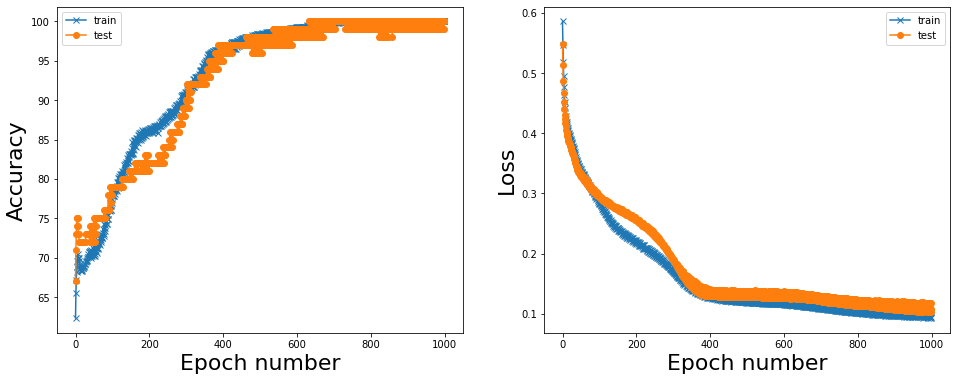

In [33]:
fig = plt.figure(figsize=(16, 6))
ax = fig.add_subplot(1, 2, 1)
ax.plot(train_logs['acc'], '-x', label='train')
ax.plot(val_logs['acc'], '-o', label='test')
ax.set_ylabel('Accuracy', size=22)
ax.set_xlabel('Epoch number', size=22)
ax.legend()

ax = fig.add_subplot(1, 2, 2)
ax.plot(train_logs['loss'], '-x', label='train')
ax.plot(val_logs['loss'], '-o', label='test')
ax.set_ylabel('Loss', size=22)
ax.set_xlabel('Epoch number', size=22)
ax.legend()